# Project: Image Classification and Regression

## 3 - Simple Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from keras.utils import np_utils, to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, UpSampling2D, Input
from keras import optimizers

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random()) * figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]



Using TensorFlow backend.


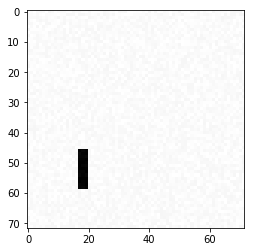

In [2]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray');

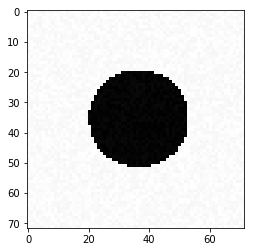

In [3]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray');

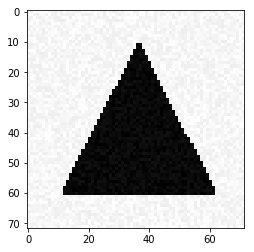

In [4]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray');

Let's try a simple multiclass linear regression. We use 20% of the dataset for evaluation. We choose a "categorical_crossentropy" loss since it is what I found on most online tutorial for multiclass classification problems, and it suits well a multiclass problem. We use a softmax function to normalize the output to a probability like format.

The problem of SGD is that one must choose the learning rate and learning rate decay, and one will usualy rely on experience or some rule of thum to choose it. Happily since computations are very fast, it is easy to try several parameters.

In [15]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, False)

Creating data:


In [6]:
model = Sequential()
model.add(Dense(3))
model.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.001, decay=0.05, momentum=0.9, nesterov=False)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy']
)

model.fit(X_train, to_categorical(Y_train), batch_size=32, epochs=10, validation_split=0.2);

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 4s 5ms/step - loss: 1.0308 - acc: 0.5425 - val_loss: 0.5912 - val_acc: 0.6900
Epoch 2/10
800/800 [==============================] - 0s 211us/step - loss: 0.4849 - acc: 0.8325 - val_loss: 0.3947 - val_acc: 0.8650
Epoch 3/10
800/800 [==============================] - 0s 212us/step - loss: 0.3751 - acc: 0.8975 - val_loss: 0.3569 - val_acc: 0.9250
Epoch 4/10
800/800 [==============================] - 0s 214us/step - loss: 0.3365 - acc: 0.9225 - val_loss: 0.3368 - val_acc: 0.9050
Epoch 5/10
800/800 [==============================] - 0s 221us/step - loss: 0.3096 - acc: 0.9438 - val_loss: 0.3108 - val_acc: 0.9450
Epoch 6/10
800/800 [==============================] - 0s 221us/step - loss: 0.2992 - acc: 0.9450 - val_loss: 0.2946 - val_acc: 0.9700
Epoch 7/10
800/800 [==============================] - 0s 231us/step - loss: 0.2832 - acc: 0.9525 - val_loss: 0.2966 - val_acc: 0.9100
Epoch 8/10
800/800

Now let's try the same model with an Adam Optimizer:

In [7]:
model = Sequential()
model.add(Dense(3))
model.add(Activation('softmax'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

model.fit(X_train, to_categorical(Y_train), batch_size=32, epochs=10, validation_split=0.2);

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 462us/step - loss: 1.1704 - acc: 0.5275 - val_loss: 0.6574 - val_acc: 0.6200
Epoch 2/10
800/800 [==============================] - ETA: 0s - loss: 0.4619 - acc: 0.808 - 0s 98us/step - loss: 0.4385 - acc: 0.8287 - val_loss: 0.3088 - val_acc: 0.9200
Epoch 3/10
800/800 [==============================] - 0s 92us/step - loss: 0.2480 - acc: 0.9487 - val_loss: 0.2277 - val_acc: 0.9800
Epoch 4/10
800/800 [==============================] - 0s 99us/step - loss: 0.2074 - acc: 0.9513 - val_loss: 0.3171 - val_acc: 0.8150
Epoch 5/10
800/800 [==============================] - 0s 140us/step - loss: 0.1733 - acc: 0.9550 - val_loss: 0.1504 - val_acc: 0.9850
Epoch 6/10
800/800 [==============================] - 0s 112us/step - loss: 0.1260 - acc: 0.9875 - val_loss: 0.1153 - val_acc: 1.0000
Epoch 7/10
800/800 [==============================] - 0s 99us/step - loss: 0.0900 - acc: 0.9988 - val_loss: 0.0947 

Using the default parameters for Adam, I get better results than after some tuning with SGD-momentum. Also validation accuracy is higher than SGD after only 3 epochs.

In [8]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
np.argmax(model.predict(X_test))  # output should be 1

1

## 4 - Visualization of the Solution

In [9]:
def normalize(im):
    return (256 * (im - np.min(im)) / (np.max(im) - np.min(im))).astype("uint8")

rectangle: 


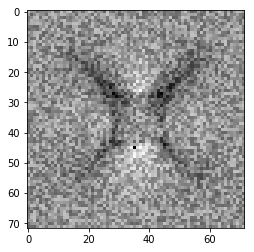

In [10]:
my_weights = []
for i in range(3):
    my_weights.append(normalize(np.reshape(model.get_weights()[0][:, i], (IMAGE_SIZE, IMAGE_SIZE))))

print("rectangle: ")
plt.imshow(my_weights[0], cmap="gray");

We can see that diagonals pixels do not activate the ractangle detector. Indeed rectangles statistically spread more to the sides than to the diagionals.

disk: 


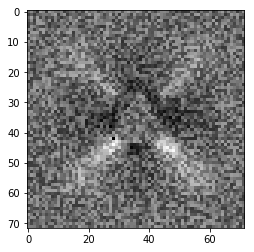

In [11]:
print("disk: ")
plt.imshow(my_weights[1], cmap="gray");

The disk detector focuses on the diagonal pixels since the disk is the only drawing that extends as much on diagonal pixels as in other directions.

triangle: 


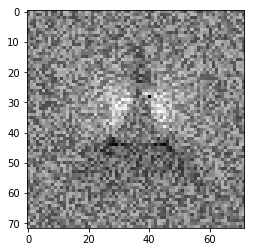

In [12]:
print("triangle: ")
plt.imshow(my_weights[2], cmap="gray");

## 5 - A More Difficult Classification Problem

In [13]:
[X_train, Y_train] = generate_dataset_classification(2000, 20, True)

Creating data:


In [14]:
model = Sequential()
model.add(Dense(3))
model.add(Activation('softmax'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

model.fit(X_train, to_categorical(Y_train), batch_size=32, epochs=20, validation_split=0.2);

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 1s 330us/step - loss: 1.7142 - acc: 0.4113 - val_loss: 1.2035 - val_acc: 0.4600
Epoch 2/20
1600/1600 [==============================] - 0s 130us/step - loss: 0.9728 - acc: 0.5369 - val_loss: 0.8846 - val_acc: 0.5475
Epoch 3/20
1600/1600 [==============================] - 0s 105us/step - loss: 0.8734 - acc: 0.5637 - val_loss: 0.8531 - val_acc: 0.6175
Epoch 4/20
1600/1600 [==============================] - 0s 98us/step - loss: 0.9176 - acc: 0.5413 - val_loss: 0.9360 - val_acc: 0.5525
Epoch 5/20
1600/1600 [==============================] - 0s 96us/step - loss: 0.8819 - acc: 0.5594 - val_loss: 0.7748 - val_acc: 0.6225
Epoch 6/20
1600/1600 [==============================] - 0s 102us/step - loss: 0.8415 - acc: 0.5950 - val_loss: 0.7861 - val_acc: 0.5875
Epoch 7/20
1600/1600 [==============================] - 0s 97us/step - loss: 0.7803 - acc: 0.6219 - val_loss: 0.8362 - val_acc: 0.5450
Epoc

It looks like this model struggles to get good results and it overfits a lot. (better results on the training set than on the testing set). Indeed, this linear model only takes into account individual pixels, and not their neighbors. The previous model, when figures were always in the middle of the image worked fine because it relied on statistical laws of the occupation of the image for different figures that are in the center. Now since images are not in the center anymore it is harder to identify those laws. We must try a more complicated model to adapt to this harder problem.

In [15]:
[X_test, Y_test] = generate_test_set_classification()
print("[loss, accuracy]: ", model.evaluate(X_test, Y_test))

Creating data:
300/300 [==============================] - 0s 74us/step
[loss, accuracy]:  [1.056453894774119, 0.5866666666666667]


Now we try a convolutionnal neural network, with two convolutional layers. We add dropout to generalize better.

In [16]:
model = Sequential()

model.add(Conv2D(16, (5, 5), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

model.fit(
    np.reshape(X_train, (X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),
    to_categorical(Y_train), batch_size=128, epochs=20, validation_split=0.2
);

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 7s 4ms/step - loss: 1.0438 - acc: 0.4738 - val_loss: 0.9199 - val_acc: 0.5625
Epoch 2/20
1600/1600 [==============================] - 6s 4ms/step - loss: 0.8576 - acc: 0.6088 - val_loss: 0.7667 - val_acc: 0.6500
Epoch 3/20
1600/1600 [==============================] - 7s 5ms/step - loss: 0.7475 - acc: 0.6512 - val_loss: 0.6847 - val_acc: 0.7200
Epoch 4/20
1600/1600 [==============================] - 9s 6ms/step - loss: 0.6873 - acc: 0.7006 - val_loss: 0.6391 - val_acc: 0.7550
Epoch 5/20
1600/1600 [==============================] - 9s 6ms/step - loss: 0.6008 - acc: 0.7563 - val_loss: 0.5742 - val_acc: 0.7775
Epoch 6/20
1600/1600 [==============================] - 11s 7ms/step - loss: 0.5487 - acc: 0.7894 - val_loss: 0.5082 - val_acc: 0.8275
Epoch 7/20
1600/1600 [==============================] - 12s 8ms/step - loss: 0.4744 - acc: 0.8287 - val_loss: 0.4373 - val_acc: 0.8550
Epoch 8/20
16

In [17]:
print(
    "[loss, accuracy]: ", 
    model.evaluate(
        np.reshape(X_test, (X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),
        Y_test
    )
)

300/300 [==============================] - 1s 2ms/step
[loss, accuracy]:  [0.16437013347943624, 0.9433333325386047]


We get much better resuts than the simple linear regression. Indeed we have added non-linearity and we also work with pixel neighbourhoods, which is much more adapted to image classification. We could probably achieve better results by adding more training examples and adding a convolutionnal layer to the model. Let's try this:

In [160]:
[X_train, Y_train] = generate_dataset_classification(10000, 20, True)

Creating data:


In [19]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

model.fit(
    np.reshape(X_train, (X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),
    to_categorical(Y_train), batch_size=128, epochs=10, validation_split=0.2
);

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 38s 5ms/step - loss: 0.8193 - acc: 0.6361 - val_loss: 0.4354 - val_acc: 0.8715
Epoch 2/10
8000/8000 [==============================] - 31s 4ms/step - loss: 0.3411 - acc: 0.8910 - val_loss: 0.1654 - val_acc: 0.9470
Epoch 3/10
8000/8000 [==============================] - 31s 4ms/step - loss: 0.2026 - acc: 0.9370 - val_loss: 0.1156 - val_acc: 0.9630
Epoch 4/10
8000/8000 [==============================] - 29s 4ms/step - loss: 0.1523 - acc: 0.9526 - val_loss: 0.0901 - val_acc: 0.9705
Epoch 5/10
8000/8000 [==============================] - 26s 3ms/step - loss: 0.1209 - acc: 0.9639 - val_loss: 0.0781 - val_acc: 0.9785
Epoch 6/10
8000/8000 [==============================] - 26s 3ms/step - loss: 0.1076 - acc: 0.9691 - val_loss: 0.0649 - val_acc: 0.9830
Epoch 7/10
8000/8000 [==============================] - 27s 3ms/step - loss: 0.0945 - acc: 0.9744 - val_loss: 0.0601 - val_acc: 0.9815
Epoch 8

Indeed we manage to get very good result with almost 100% validation accuracy. 100% is hard to achieve since even for humans, it is not easy to classify between a very flat recatngle and a very flat triangle.

## 6 - A Regression Problem

In [16]:
def generate_dataset_regression(nb_samples, noise=0.0, free_location=True):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, 6, 6])
    print('Creating data:')
    for i in range(nb_samples):
        [X[i], current] = generate_a_triangle(noise, free_location=free_location)
        
        ans = []
        for k in range(3):
            for j in range(3):
                for l in range(3):
                    if j != l and k != j and k !=l:
                        ans.append(
                            [current[2 * k], current[2 * k + 1], current[2 * j],
                             current[2 * j + 1], current[2 * l], current[2 * l + 1]]
                        )
        Y[i] = np.array(ans)
        
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression(free_location=True):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20, free_location=free_location)
    return [X_test, Y_test]

In [46]:
[X_train, Y_train] = generate_dataset_regression(15000, 20, free_location=True)

Creating data:


Since coordinates of triangles are an array of size 6, we build a regressor with an outpout of size 6. But since the output are the coordinates of 3 points and that we do not care in which order it should output them, I defined a custom loss. We compare the output of the regression whith every possible arrangement of the three points coordinates. So the regressor will have the same loss for an output of format [a, b, c] and [b, a, c].

In [47]:
import keras.backend.tensorflow_backend as K
def my_loss(y_true, y_pred):
    return K.min(K.sum(K.square(y_pred - y_true), axis=-1), axis=1)

In [48]:
from keras.layers import BatchNormalization, RepeatVector

model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(6))
model.add(RepeatVector(6))

training_generator = DataGenerator()
validation_generator = DataGenerator(batch_per_epoch=1)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(
    loss=my_loss,
    optimizer=adam
)



In [49]:
model.fit(
    np.reshape(X_train, (X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),
    Y_train, batch_size=256, epochs=150, validation_split=0.05
);

Train on 14250 samples, validate on 750 samples
Epoch 1/150
14250/14250 [==============================] - 6s 390us/step - loss: 0.3064 - val_loss: 0.1406
Epoch 2/150
14250/14250 [==============================] - 3s 242us/step - loss: 0.1460 - val_loss: 0.0972
Epoch 3/150
14250/14250 [==============================] - 3s 245us/step - loss: 0.1148 - val_loss: 0.0734
Epoch 4/150
14250/14250 [==============================] - 3s 245us/step - loss: 0.0993 - val_loss: 0.0627
Epoch 5/150
14250/14250 [==============================] - 3s 245us/step - loss: 0.0904 - val_loss: 0.0576
Epoch 6/150
14250/14250 [==============================] - 4s 247us/step - loss: 0.0853 - val_loss: 0.0556A: 0s -
Epoch 7/150
14250/14250 [==============================] - 3s 245us/step - loss: 0.0810 - val_loss: 0.0516oss: 0. - ETA:
Epoch 8/150
14250/14250 [==============================] - 3s 246us/step - loss: 0.0780 - val_loss: 0.0490
Epoch 9/150
14250/14250 [==============================] - 4s 250us/step - 

Epoch 71/150
14250/14250 [==============================] - 4s 254us/step - loss: 0.0486 - val_loss: 0.0310
Epoch 72/150
14250/14250 [==============================] - ETA: 0s - loss: 0.0481- ETA: 1s - loss: - ETA: 1s - loss:  - ETA - 3s 244us/step - loss: 0.0481 - val_loss: 0.0310
Epoch 73/150
14250/14250 [==============================] - 4s 254us/step - loss: 0.0479 - val_loss: 0.0310 0.
Epoch 74/150
14250/14250 [==============================] - 3s 245us/step - loss: 0.0488 - val_loss: 0.0307
Epoch 75/150
14250/14250 [==============================] - 4s 255us/step - loss: 0.0481 - val_loss: 0.0307
Epoch 76/150
14250/14250 [==============================] - 4s 272us/step - loss: 0.0477 - val_loss: 0.0305
Epoch 77/150
14250/14250 [==============================] - 4s 276us/step - loss: 0.0480 - val_loss: 0.0306
Epoch 78/150
14250/14250 [==============================] - 3s 245us/step - loss: 0.0475 - val_loss: 0.0308 ETA - ETA: 1s - - ETA: 
Epoch 79/150
14250/14250 [================

14250/14250 [==============================] - 3s 245us/step - loss: 0.0428 - val_loss: 0.0283.0
Epoch 139/150
14250/14250 [==============================] - 4s 246us/step - loss: 0.0433 - val_loss: 0.0282
Epoch 140/150
14250/14250 [==============================] - 3s 246us/step - loss: 0.0430 - val_loss: 0.0282oss: 0. - ETA:
Epoch 141/150
14250/14250 [==============================] - 4s 249us/step - loss: 0.0431 - val_loss: 0.0285
Epoch 142/150
14250/14250 [==============================] - 4s 249us/step - loss: 0.0433 - val_loss: 0.0281
Epoch 143/150
14250/14250 [==============================] - 4s 254us/step - loss: 0.0427 - val_loss: 0.0282
Epoch 144/150
14250/14250 [==============================] - 4s 246us/step - loss: 0.0429 - val_loss: 0.0280 2s - loss: 0.04 - E - ETA: 0s - lo
Epoch 145/150
14250/14250 [==============================] - 3s 242us/step - loss: 0.0423 - val_loss: 0.0281
Epoch 146/150
14250/14250 [==============================] - 3s 240us/step - loss: 0.0428 -

In [50]:
[X_test, Y_test] = generate_test_set_regression(free_location=True)

print(
    "[loss]: ", 
    model.evaluate(
        np.reshape(X_test, (X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),
        Y_test
    )
)

Creating data:
300/300 [==============================] - 0s 180us/step
[loss]:  0.028892282942930857


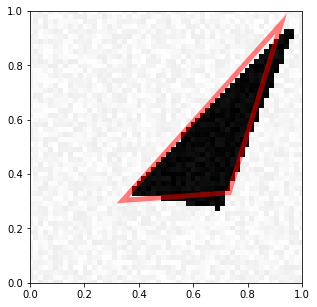

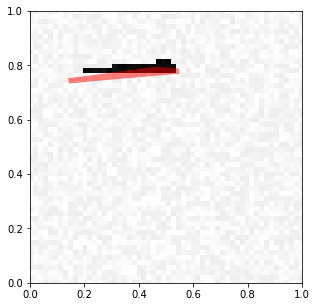

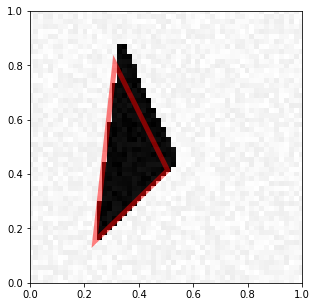

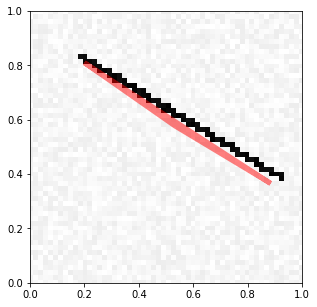

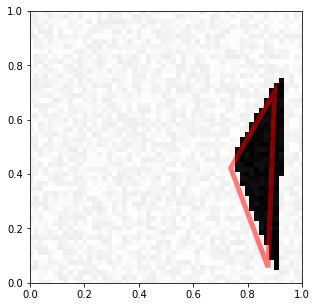

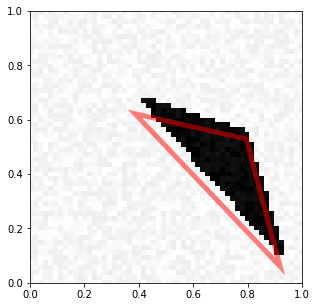

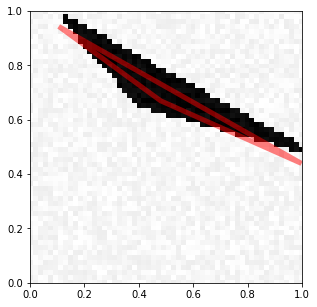

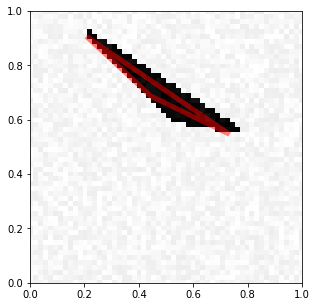

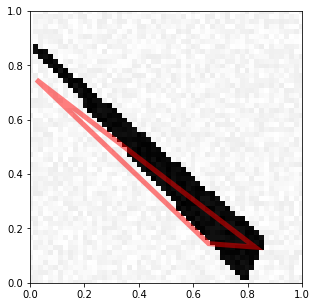

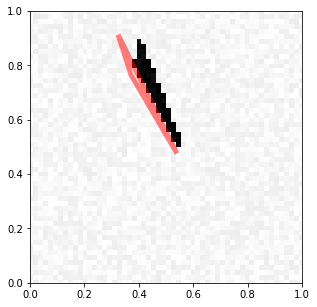

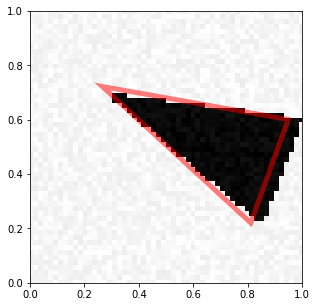

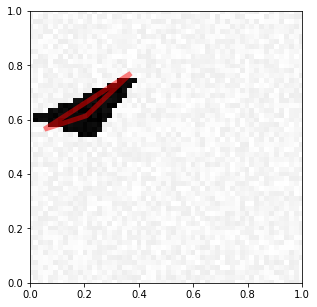

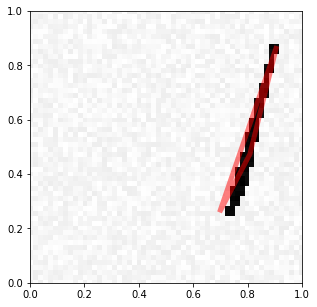

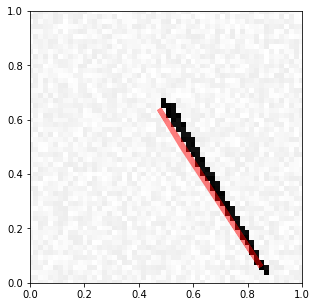

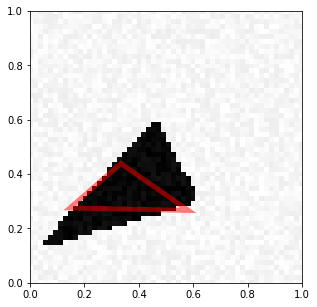

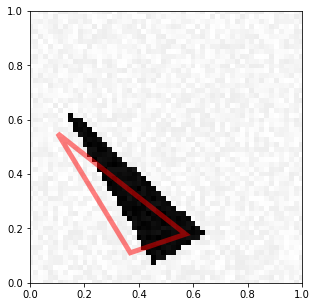

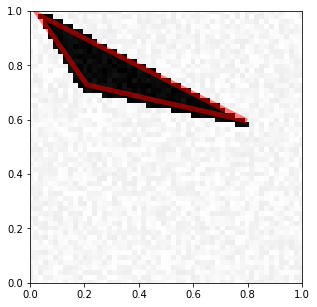

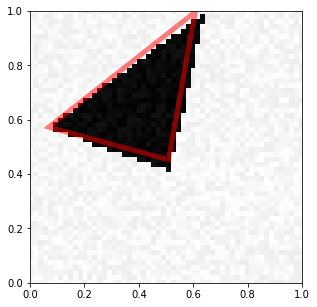

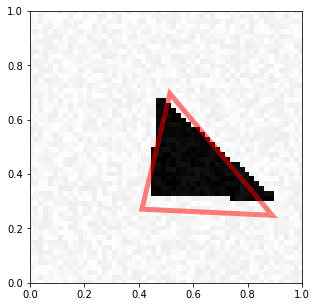

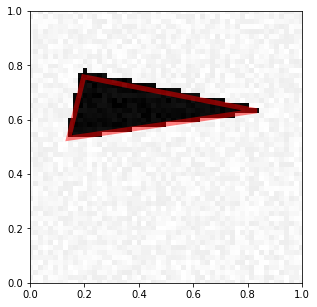

In [72]:
y_pred = model.predict(np.reshape(X_test, (X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)))
for i in range(20):
    visualize_prediction(X_test[i], y_pred[i][0])

We get a low mean squared error and by visualizing the results we can confirm that the regression is working quite well. We could probably get better results if we did a more complex model. For example learn to detect a triangle corner and then output the points on the image that are more likely to be a triangle corner. Then we can rebuild the triangle from this ouput.

## 7 - Image Denoising

To create the dataset, we just create the same drawings, were the input one is noisy and the target one is the same target but without noise.  

In [26]:
def generate_dataset_denoising(nb_samples, noise=10., free_location=True):
    im_size = generate_a_rectangle().shape[0]
    x = np.zeros([nb_samples,im_size])
    y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        np.random.seed(i)
        if category == 0:
            x[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            x[i] = generate_a_disk(noise, free_location)
        else:
            [x[i], v] = generate_a_triangle(noise, free_location)
        
        np.random.seed(i)
        if category == 0:
            y[i] = generate_a_rectangle(0., free_location)
        elif category == 1: 
            y[i] = generate_a_disk(0., free_location)
        else:
            [y[i], v] = generate_a_triangle(0., free_location)
    x = (x + noise) / (255 + 2 * noise)
    y = y / 255.
    return [x, y]

In [27]:
X_train, Y_train = generate_dataset_denoising(4000, noise=50)

Creating data:


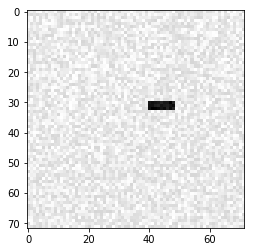

In [28]:
plt.imshow(np.reshape(X_train[0, :], (IMAGE_SIZE, IMAGE_SIZE)), cmap="gray");

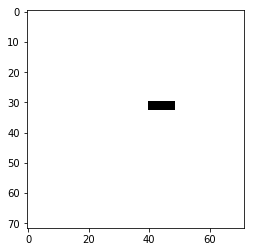

In [29]:
plt.imshow(np.reshape(Y_train[0, :], (IMAGE_SIZE, IMAGE_SIZE)), cmap="gray");

Hourglass models reduce use convolutions and max pooling. This reduces the size of the images. And then use convolutions and upsampling to create a bigger image to match the size of the output. We are going to train those convolution layers to get rid of the noise in the image.

In [30]:
input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same', activation="sigmoid")(x)

model = Model(input_img, decoded)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

model.compile(optimizer=adam, loss='mean_squared_error')

In [31]:
model.fit(
    np.reshape(X_train, (X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),
    np.reshape(Y_train, (X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)),
    epochs=3,
    batch_size=64,
    validation_split=0.2
);

Train on 3200 samples, validate on 800 samples
Epoch 1/3
3200/3200 [==============================] - 47s 15ms/step - loss: 0.0868 - val_loss: 0.0438
Epoch 2/3
3200/3200 [==============================] - 42s 13ms/step - loss: 0.0256 - val_loss: 0.0102
Epoch 3/3
3200/3200 [==============================] - 48s 15ms/step - loss: 0.0066 - val_loss: 0.0046


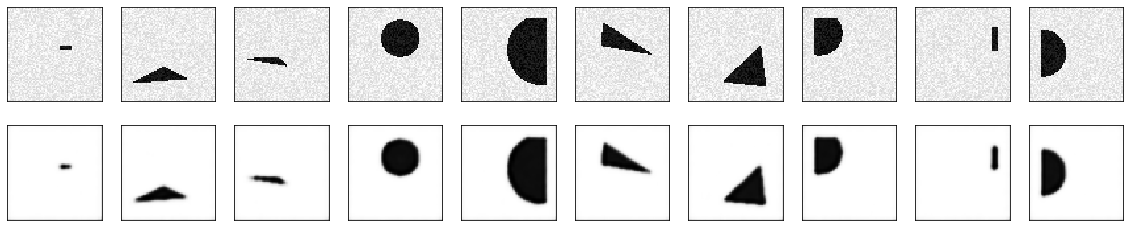

In [32]:
n = 10
decoded_imgs = model.predict(np.reshape(X_train[:n], (n, IMAGE_SIZE, IMAGE_SIZE, 1)))

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(decoded_imgs[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Results are good at denoising, but they tend to blur the edges of the figures.